In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import datetime

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from prophet import Prophet
from xgboost import XGBRegressor

C:\Users\20200628\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
price_data_file = os.path.join(parent_dir, 'data', 'price_data.csv')
hourly_consumption_file = os.path.join(parent_dir, 'data', 'hourly_consumption_data.csv')
individual_houses = os.path.join(parent_dir, 'data', 'individual_houses.csv')
one_month_uninterupted = os.path.join(parent_dir, 'data', 'one_month_uninterupted.csv')
houses_one_month_uninterupted = os.path.join(parent_dir, 'data', 'houses_one_month_uninterupted.csv')

In [3]:
df = pd.read_csv(hourly_consumption_file, index_col='Time')
df

,Consumption
Time,
2017-10-21 00:00:00,0.027951
2017-10-21 01:00:00,0.056724
2017-10-21 02:00:00,0.028021
2017-10-21 03:00:00,0.057001
2017-10-21 04:00:00,0.027773
...,...
2018-07-26 19:00:00,0.119373
2018-07-26 20:00:00,0.048830
2018-07-26 21:00:00,0.043194


In [4]:
df.describe()

,Consumption
count,5589.000000
mean,0.198446
std,0.263227
min,0.024083
25%,0.047398
50%,0.076023
75%,0.249885
max,2.134392


### Data Transformation and EDA

In [5]:
df.index = pd.to_datetime(df.index, format='%Y-%m-%d %H:%M:%S')
df.index

DatetimeIndex(['2017-10-21 00:00:00', '2017-10-21 01:00:00',
               '2017-10-21 02:00:00', '2017-10-21 03:00:00',
               '2017-10-21 04:00:00', '2017-10-21 05:00:00',
               '2017-10-21 06:00:00', '2017-10-21 07:00:00',
               '2017-10-21 08:00:00', '2017-10-21 09:00:00',
               ...
               '2018-07-26 14:00:00', '2018-07-26 15:00:00',
               '2018-07-26 16:00:00', '2018-07-26 17:00:00',
               '2018-07-26 18:00:00', '2018-07-26 19:00:00',
               '2018-07-26 20:00:00', '2018-07-26 21:00:00',
               '2018-07-26 22:00:00', '2018-07-26 23:00:00'],
              dtype='datetime64[ns]', name='Time', length=5589, freq=None)

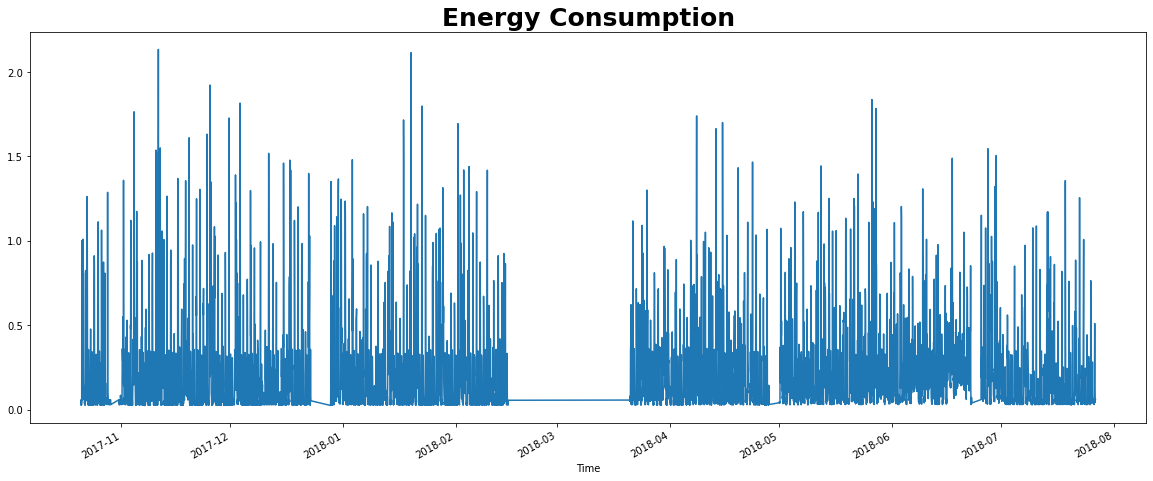

In [7]:
df['Consumption'].plot(figsize=(20,8))
plt.title('Energy Consumption', weight='bold', fontsize=25);

As you can see some data is missing/ is 0, for these values, I have decided to predict solely on a one month basis where every hour of the day is given. This will lead (hopefully) to the best precision.

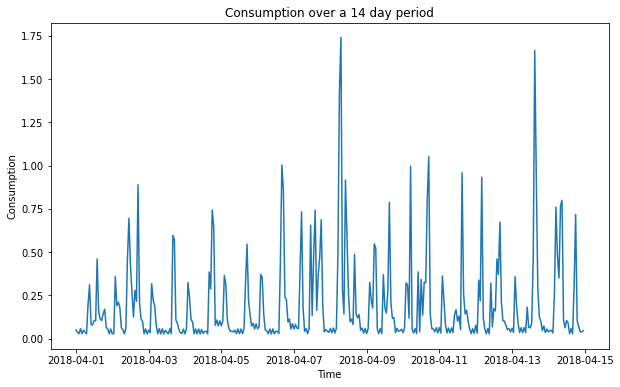

In [8]:
mask = (df.index >= '2018-04-01 00:00:00') & (df.index <= '2018-04-14 23:00:00')
filtered_df = df.loc[mask]

# Plot the data
plt.figure(figsize=(10,6))
plt.plot(filtered_df.index, filtered_df['Consumption'])
plt.xlabel('Time')
plt.ylabel('Consumption')
plt.title('Consumption over a 14 day period')
plt.show()

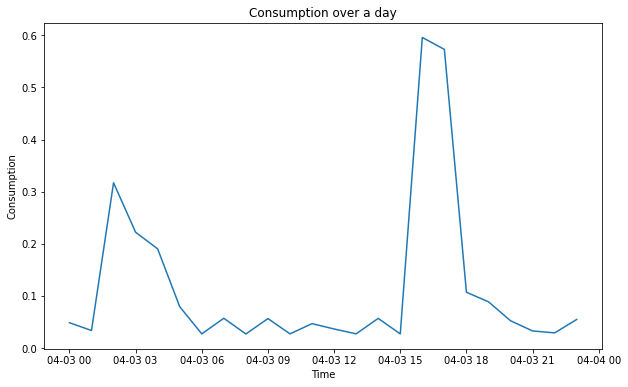

In [9]:
mask = (df.index >= '2018-04-03 00:00:00') & (df.index <= '2018-04-03 23:00:00')
filtered_df = df.loc[mask]

# Plot the data
plt.figure(figsize=(10,6))
plt.plot(filtered_df.index, filtered_df['Consumption'])
plt.xlabel('Time')
plt.ylabel('Consumption')
plt.title('Consumption over a day')
plt.show()

In [10]:
df['Hour'] = df.index.hour
df['Day'] = df.index.day
df['Month'] = df.index.month
df['Quarter'] = df.index.quarter
df['Year'] = df.index.year


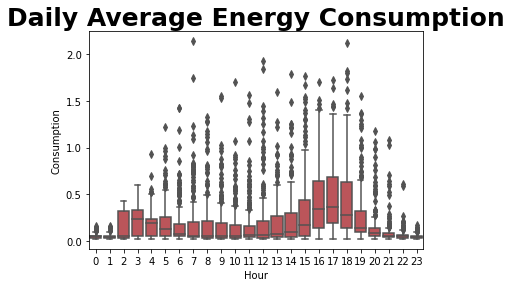

In [11]:
ax = sns.boxplot(data=df, x='Hour', y='Consumption', color='#cc444b')
ax.set_title('Daily Average Energy Consumption', weight='bold', fontsize=25);

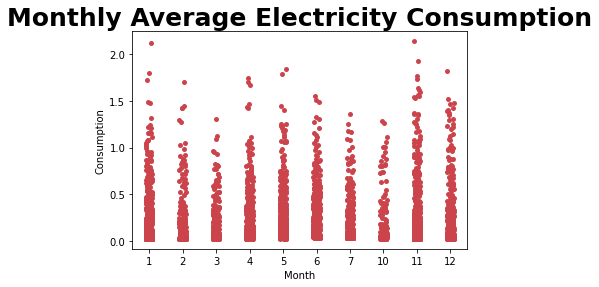

In [12]:
ax = sns.stripplot(data=df, x='Month', y='Consumption', color='#cc444b')
ax.set_title('Monthly Average Electricity Consumption', weight='bold', fontsize=25);

In [13]:
plt.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=['#cc444b', '#e89005'])

# All Data

## EDA

In [14]:
df_total_houses = pd.read_csv(individual_houses, index_col='Time')
df_total_houses.describe()

,House 1 Consumption,House 2 Consumption,House 3 Consumption,House 4 Consumption,House 5 Consumption,House 6 Consumption,House 7 Consumption,House 8 Consumption,House 9 Consumption,House 10 Consumption,House 11 Consumption,House 12 Consumption,House 13 Consumption,House 14 Consumption,House 15 Consumption
count,5589.000000,5589.000000,5589.000000,5589.000000,5589.000000,5589.000000,5589.000000,5589.000000,5589.000000,5589.000000,5589.000000,5589.000000,5589.000000,5589.000000,5589.000000
mean,0.198818,0.197493,0.199519,0.198145,0.196687,0.199341,0.198647,0.197640,0.199320,0.198182,0.199382,0.199517,0.197314,0.198318,0.198727
std,0.272433,0.268788,0.272575,0.269327,0.265777,0.271560,0.271503,0.269316,0.270580,0.271353,0.273117,0.273231,0.269019,0.269444,0.273841
min,0.007698,0.009476,0.012133,0.011263,0.007086,0.007983,0.011430,0.012695,0.012555,0.013094,0.009931,0.011397,0.010195,0.007870,0.012082
25%,0.043280,0.043590,0.043910,0.044265,0.043797,0.044237,0.043943,0.043937,0.043791,0.044352,0.044142,0.044277,0.043922,0.044096,0.043664
50%,0.077105,0.077222,0.077378,0.076317,0.077199,0.076503,0.076876,0.078013,0.077501,0.076521,0.077170,0.076688,0.076561,0.077553,0.076599
75%,0.242870,0.243539,0.247508,0.244227,0.245432,0.249513,0.248111,0.246494,0.248040,0.243250,0.243324,0.246550,0.247240,0.240817,0.247352
max,2.511961,2.429432,2.294787,2.786303,2.469647,2.565852,2.373549,2.328693,2.337045,2.333137,2.503719,2.553943,3.020064,2.239978,2.740207


<Axes: xlabel='Time'>

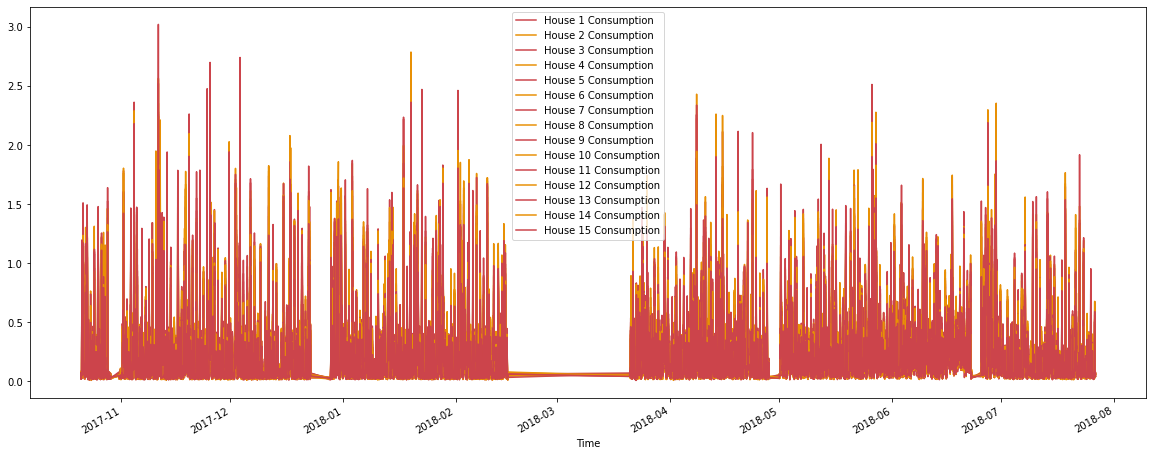

In [15]:
df_total_houses.index = pd.to_datetime(df_total_houses.index)

df_total_houses.plot(figsize=(20,8))

In [16]:
df_total_houses['Hour'] = df_total_houses.index.hour
df_total_houses['Day'] = df_total_houses.index.day
df_total_houses['Month'] = df_total_houses.index.month
df_total_houses['Quarter'] = df_total_houses.index.quarter
df_total_houses['Year'] = df_total_houses.index.year

df_total_houses.head(3)

,House 1 Consumption,House 2 Consumption,House 3 Consumption,House 4 Consumption,House 5 Consumption,House 6 Consumption,House 7 Consumption,House 8 Consumption,House 9 Consumption,House 10 Consumption,House 11 Consumption,House 12 Consumption,House 13 Consumption,House 14 Consumption,House 15 Consumption,Hour,Day,Month,Quarter,Year
Time,,,,,,,,,,,,,,,,,,,,
2017-10-21 00:00:00,0.021078,0.030934,0.036621,0.029738,0.025639,0.025998,0.032931,0.038195,0.030454,0.029653,0.026664,0.027893,0.020251,0.027781,0.033311,0,21,10,4,2017
2017-10-21 01:00:00,0.053833,0.064004,0.051559,0.035536,0.061702,0.056889,0.087077,0.074045,0.048543,0.034148,0.043001,0.060187,0.041852,0.082297,0.073776,1,21,10,4,2017
2017-10-21 02:00:00,0.025500,0.023700,0.029079,0.028968,0.026693,0.026208,0.032603,0.025896,0.023723,0.031513,0.024780,0.032704,0.026932,0.031303,0.017586,2,21,10,4,2017


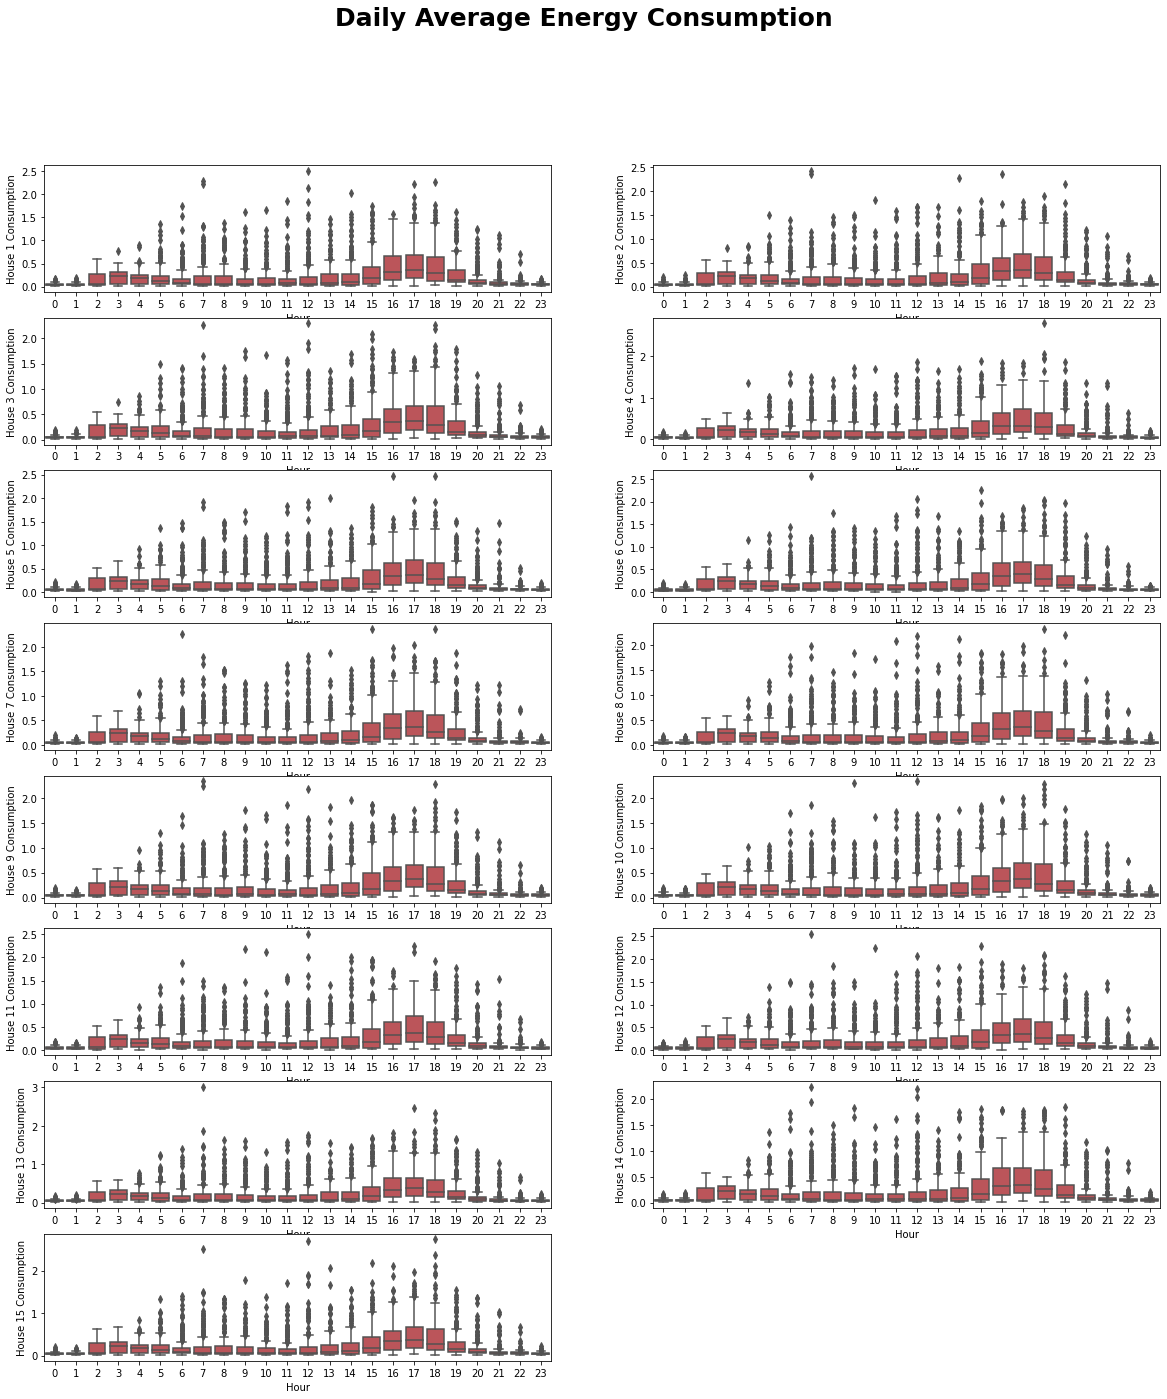

In [17]:
columns = ['House 1 Consumption', 'House 2 Consumption', 'House 3 Consumption', 'House 4 Consumption', 'House 5 Consumption', 
           'House 6 Consumption', 'House 7 Consumption', 'House 8 Consumption', 'House 9 Consumption', 'House 10 Consumption', 
           'House 11 Consumption', 'House 12 Consumption', 'House 13 Consumption', 'House 14 Consumption', 'House 15 Consumption']

f, axes = plt.subplots(nrows=8, ncols=2, figsize=(20, 22))
f.suptitle('Daily Average Energy Consumption', weight='bold', fontsize=25)
f.delaxes(axes[7][1])

for i, col in enumerate(columns):
    sns.boxplot(data=df_total_houses, x='Hour', y=col, ax=axes.flatten()[i], color='#cc444b')

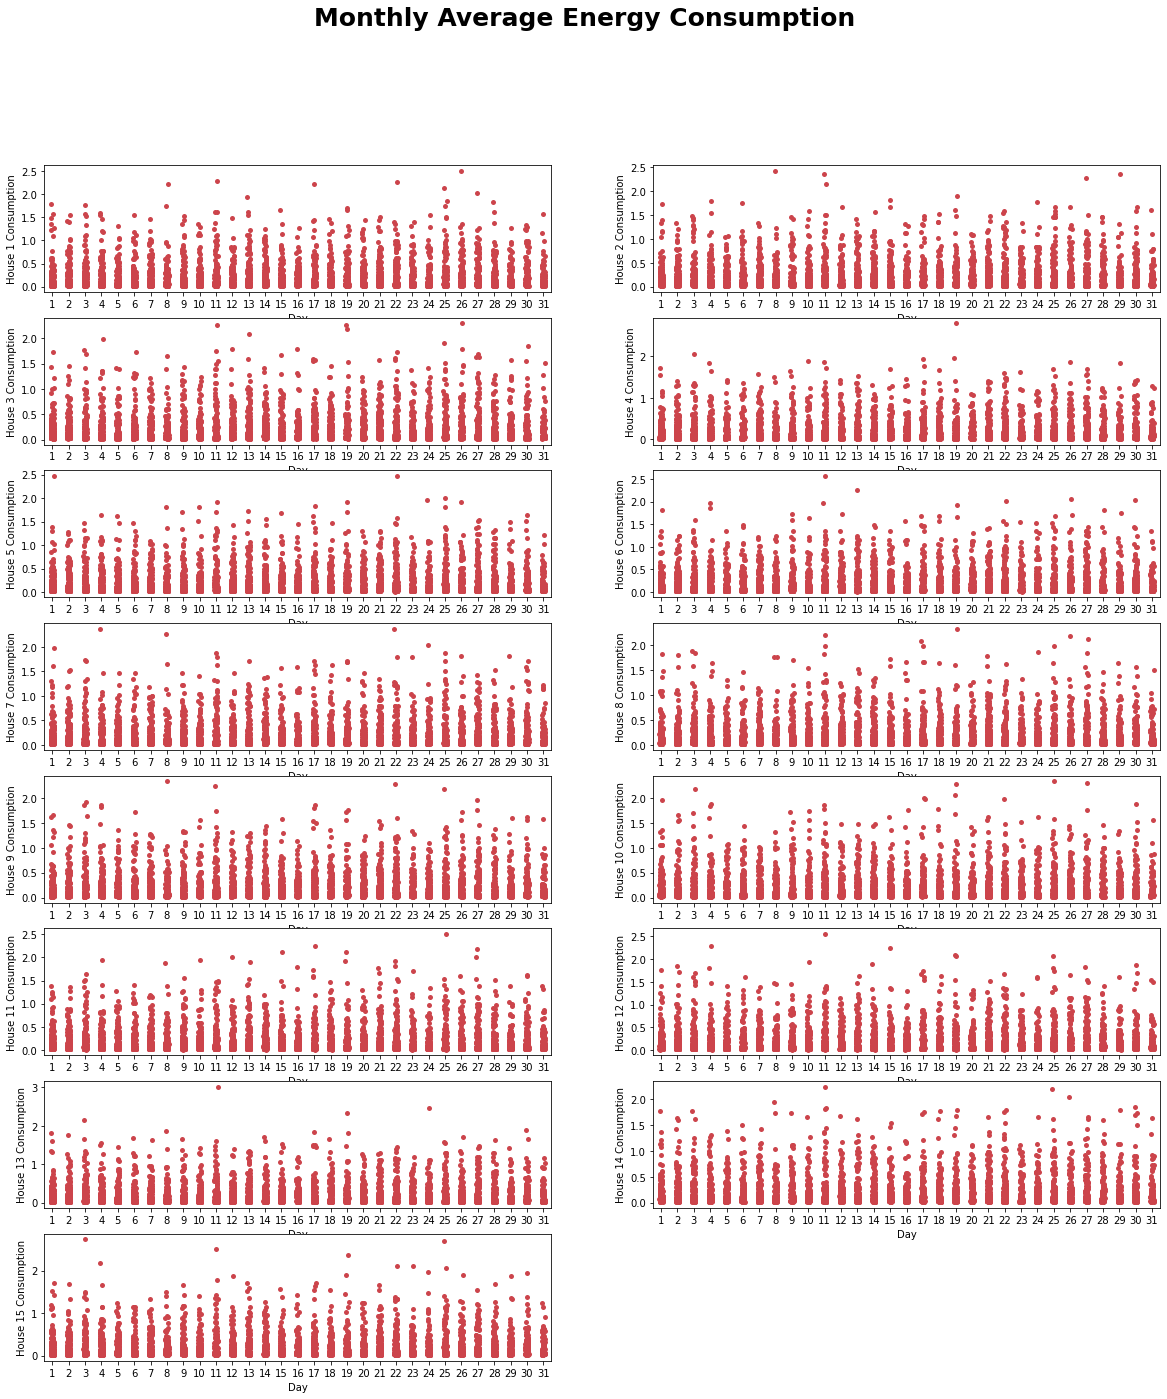

In [18]:
f, axes = plt.subplots(nrows=8, ncols=2, figsize=(20, 22))
f.suptitle('Monthly Average Energy Consumption', weight='bold', fontsize=25)
# We just need 11 figures, so we delete the last one
f.delaxes(axes[7][1])

for i, col in enumerate(columns):
    sns.stripplot(data=df_total_houses, x='Day', y=col, ax=axes.flatten()[i], color='#cc444b')

### We will use House 1 for the prediction modelling

The approach for all houses are the same, but the prediction will be run separately for each house to the simulation to validate it.

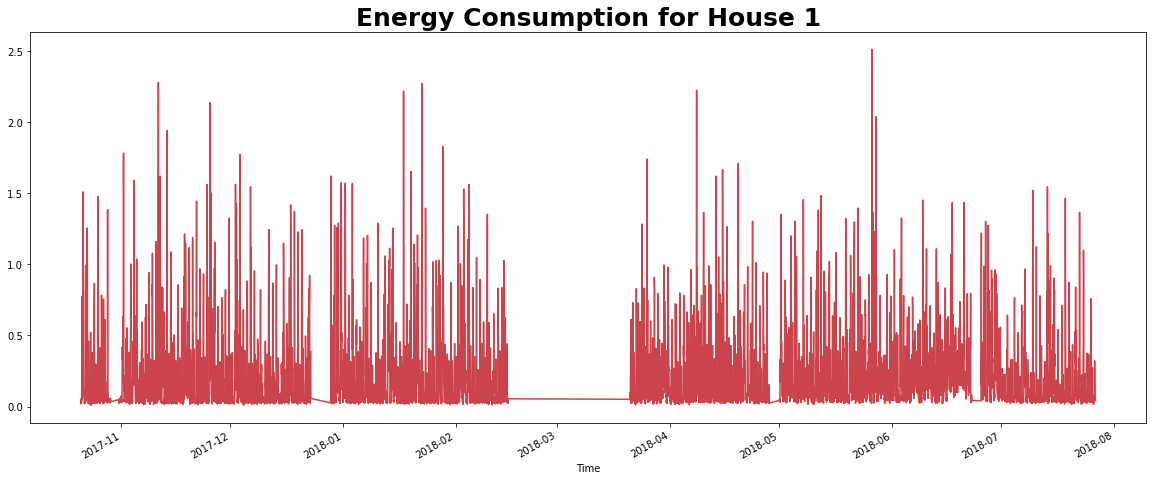

In [19]:
df_house1 = df_total_houses['House 1 Consumption']
df_house1.plot(figsize=(20,8))
plt.title('Energy Consumption for House 1', weight='bold', fontsize=25);

In [20]:
df_house1_train, df_house1_test = df_house1[df_house1.index < '2018-07-01'], df_house1[df_house1.index >= '2018-07-01']

print('Train:\t', len(df_house1_train))
print('Test:\t', len(df_house1_test))

Train:	 4965
Test:	 624


In [21]:
df_house1_train

Time
2017-10-21 00:00:00    0.021078
2017-10-21 01:00:00    0.053833
2017-10-21 02:00:00    0.025500
2017-10-21 03:00:00    0.050318
2017-10-21 04:00:00    0.024360
                         ...   
2018-06-30 19:00:00    0.528052
2018-06-30 20:00:00    0.558267
2018-06-30 21:00:00    0.179814
2018-06-30 22:00:00    0.121955
2018-06-30 23:00:00    0.068381
Name: House 1 Consumption, Length: 4965, dtype: float64

In [22]:
df_house1_test

Time
2018-07-01 00:00:00    0.068595
2018-07-01 01:00:00    0.072058
2018-07-01 02:00:00    0.053285
2018-07-01 03:00:00    0.077833
2018-07-01 04:00:00    0.089037
                         ...   
2018-07-26 19:00:00    0.126517
2018-07-26 20:00:00    0.049806
2018-07-26 21:00:00    0.045878
2018-07-26 22:00:00    0.056903
2018-07-26 23:00:00    0.043614
Name: House 1 Consumption, Length: 624, dtype: float64

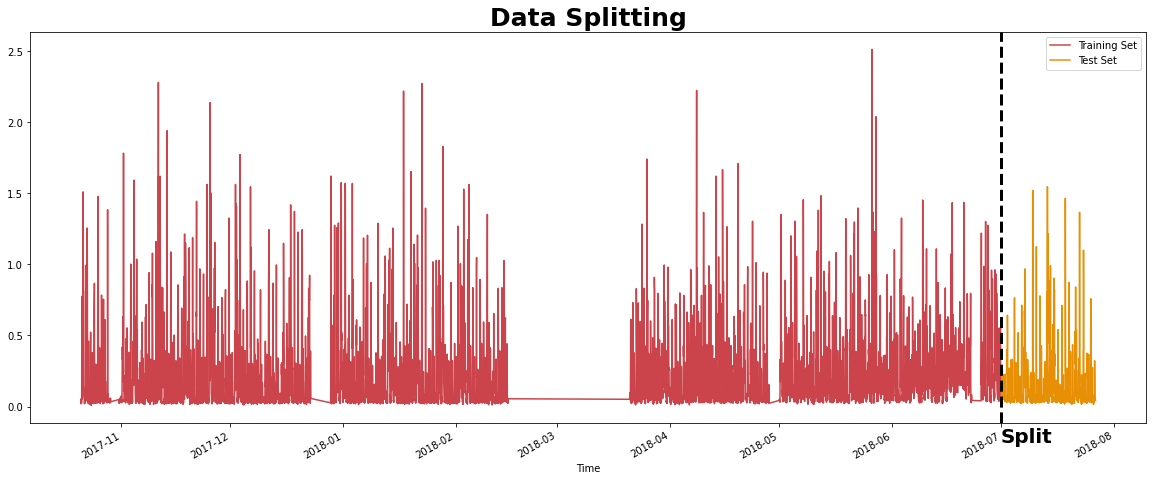

In [23]:
plt.figure(figsize=(20,8)) # lower dpi

df_house1_train.plot(label='Training Set')
df_house1_test.plot(label='Test Set')
plt.axvline('2018-07-01', color='black', ls='--', lw=3)
plt.text('2018-07-01', -0.25, 'Split', fontsize=20, fontweight='bold')
plt.title('Data Splitting', weight='bold', fontsize=25)
plt.legend();

## Modelling

### 1. Prophet

#### For some reason, after updating the library, it gives a lot of errors, I don't know why, but yeah.

Prophet is an open-source library for univariate (one variable) time series forecasting developed by Facebook. It works best with time series that have strong seasonal effects and several seasons of historical data

Official Documentation: [Here](http://facebook.github.io/prophet/#:~:text=Prophet%20is%20a%20procedure%20for,several%20seasons%20of%20historical%20data.)

Helpful Resources: 
* https://machinelearningmastery.com/time-series-forecasting-with-prophet-in-python/
* https://www.kaggle.com/code/prashant111/tutorial-time-series-forecasting-with-prophet/notebook

In [24]:
def index_to_column(data):
    data = data.reset_index()
    data['Time'] = pd.to_datetime(data['Time'])
    data = data.sort_values('Time')
    
    data = data.rename(columns={'Time': 'ds', 'House 1 Consumption': 'y'})
    return data

In [25]:
prophet_train = index_to_column(df_house1_train)
prophet_test = index_to_column(df_house1_test)

In [26]:
prophet_train

,ds,y
0,2017-10-21 00:00:00,0.021078
1,2017-10-21 01:00:00,0.053833
2,2017-10-21 02:00:00,0.025500
3,2017-10-21 03:00:00,0.050318
4,2017-10-21 04:00:00,0.024360
...,...,...
4960,2018-06-30 19:00:00,0.528052
4961,2018-06-30 20:00:00,0.558267
4962,2018-06-30 21:00:00,0.179814
4963,2018-06-30 22:00:00,0.121955


In [27]:
prophet_model = Prophet(interval_width=0.95)

prophet_model.fit(prophet_train)
prophet_pred = prophet_model.predict(prophet_test[['ds']])

16:25:33 - cmdstanpy - INFO - Chain [1] start processing
16:25:34 - cmdstanpy - INFO - Chain [1] done processing


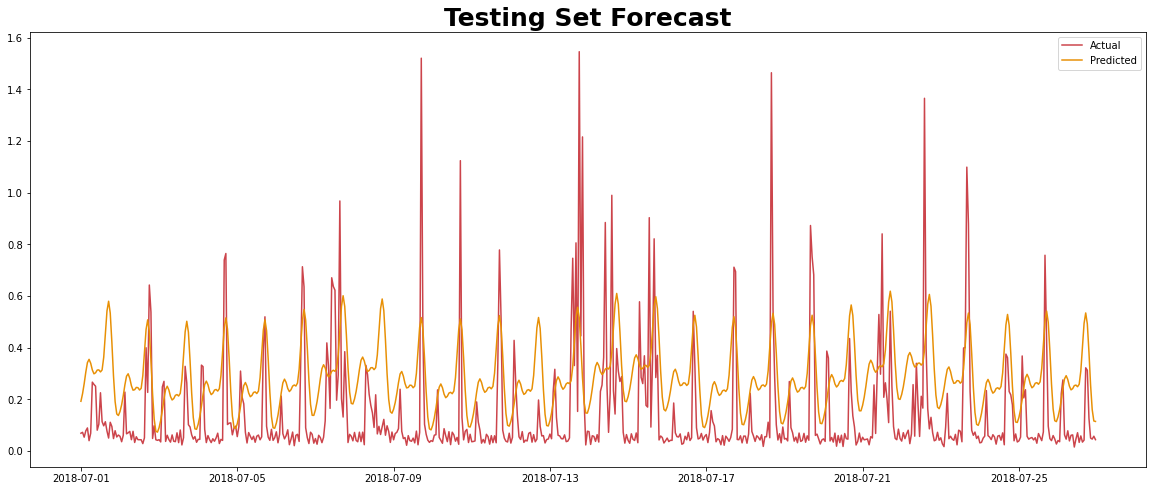

In [28]:
plt.figure(figsize=(20,8))
plt.plot(prophet_test['ds'], prophet_test['y'], label='Actual')
plt.plot(prophet_pred['ds'], prophet_pred['yhat'], label='Predicted')
plt.title('Test Forecasting', weight='bold', fontsize=40)
#plt.text(16770, 3250, 'MAE: {}'.format(mae), fontsize=20, color='red')
plt.title('Testing Set Forecast', weight='bold', fontsize=25)
plt.legend();

In [29]:
mse = mean_squared_error(prophet_test['y'], prophet_pred['yhat'])
print('MSE: ', mse)


MSE:  0.05569175517564156


### 2. XGBoost

XGBoost is short for Extreme Gradient Boosting and is an efficient implementation of the stochastic gradient boosting machine learning algorithm

The stochastic gradient boosting algorithm, also called gradient boosting machines or tree boosting, is a powerful machine learning technique that performs well or even best on a wide range of challenging machine learning problems

To be able to use XGBoost for time series forecasting, the data should be transformed into supervised learning before feeding it into the model

Official Documentation: [here](https://xgboost.readthedocs.io/en/stable/python/python_api.html)

Helpful Resources:
* https://machinelearningmastery.com/xgboost-for-time-series-forecasting/
* https://www.kaggle.com/code/robikscube/tutorial-time-series-forecasting-with-xgboost

In [30]:
def date_transform(data):
    df = pd.DataFrame(data.values, index=data.index, columns=["House 1 Consumption"])
    
    df['Hour'] = df.index.hour
    df['Day'] = df.index.day
    df['Dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.weekofyear
    df['Month'] = df.index.month
    df['Quarter'] = df.index.quarter
    df['Year'] = df.index.year
    
    X = df.drop('House 1 Consumption', axis=1)
    y = df['House 1 Consumption']
    
    return X, y

In [31]:
X_train, y_train = date_transform(df_house1_train)
X_test, y_test = date_transform(df_house1_test)

C:\Users\20200628\AppData\Local\Temp\ipykernel_20364\317430643.py:7: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['weekofyear'] = df.index.weekofyear
C:\Users\20200628\AppData\Local\Temp\ipykernel_20364\317430643.py:7: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['weekofyear'] = df.index.weekofyear


In [32]:
xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.05, early_stopping_rounds=10)
xgb_model.fit(X_train, y_train, eval_metric='mae', eval_set=[(X_train, y_train), (X_test, y_test)])
xgb_pred = xgb_model.predict(X_test)

[0]	validation_0-mae:0.35998	validation_1-mae:0.38669
[1]	validation_0-mae:0.34780	validation_1-mae:0.37608
[2]	validation_0-mae:0.33630	validation_1-mae:0.36577
[3]	validation_0-mae:0.32545	validation_1-mae:0.35661
[4]	validation_0-mae:0.31525	validation_1-mae:0.34620
[5]	validation_0-mae:0.30559	validation_1-mae:0.33763
[6]	validation_0-mae:0.29649	validation_1-mae:0.32834
[7]	validation_0-mae:0.28792	validation_1-mae:0.31906
[8]	validation_0-mae:0.27972	validation_1-mae:0.31078
[9]	validation_0-mae:0.27206	validation_1-mae:0.30248
[10]	validation_0-mae:0.26477	validation_1-mae:0.29508
[11]	validation_0-mae:0.25795	validation_1-mae:0.28756
[12]	validation_0-mae:0.25157	validation_1-mae:0.28080
[13]	validation_0-mae:0.24549	validation_1-mae:0.27413
[14]	validation_0-mae:0.23985	validation_1-mae:0.26778
[15]	validation_0-mae:0.23447	validation_1-mae:0.26244
[16]	validation_0-mae:0.22943	validation_1-mae:0.25763
[17]	validation_0-mae:0.22464	validation_1-mae:0.25306
[18]	validation_0-ma

C:\Users\20200628\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[36]	validation_0-mae:0.16915	validation_1-mae:0.19287
[37]	validation_0-mae:0.16753	validation_1-mae:0.19140
[38]	validation_0-mae:0.16601	validation_1-mae:0.19003
[39]	validation_0-mae:0.16459	validation_1-mae:0.19058
[40]	validation_0-mae:0.16321	validation_1-mae:0.18951
[41]	validation_0-mae:0.16198	validation_1-mae:0.18846
[42]	validation_0-mae:0.16080	validation_1-mae:0.18703
[43]	validation_0-mae:0.15973	validation_1-mae:0.18566
[44]	validation_0-mae:0.15875	validation_1-mae:0.18452
[45]	validation_0-mae:0.15763	validation_1-mae:0.18374
[46]	validation_0-mae:0.15660	validation_1-mae:0.18274
[47]	validation_0-mae:0.15575	validation_1-mae:0.18177
[48]	validation_0-mae:0.15479	validation_1-mae:0.18113
[49]	validation_0-mae:0.15387	validation_1-mae:0.18044
[50]	validation_0-mae:0.15288	validation_1-mae:0.17877
[51]	validation_0-mae:0.15219	validation_1-mae:0.17800
[52]	validation_0-mae:0.15139	validation_1-mae:0.17762
[53]	validation_0-mae:0.15077	validation_1-mae:0.17693
[54]	valid

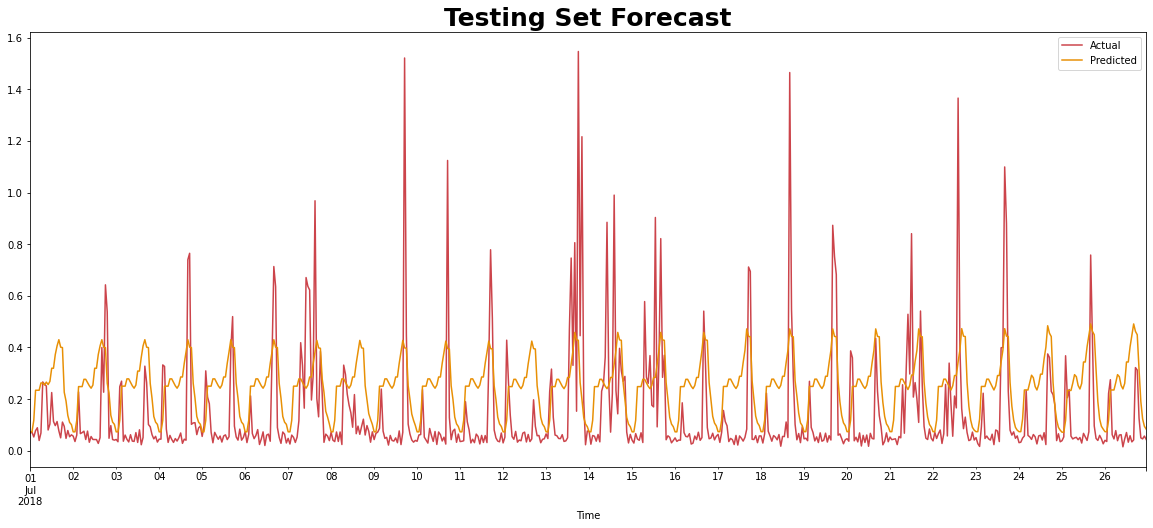

In [33]:
df_plot = pd.DataFrame({'y_test':y_test, 'xgb_pred':xgb_pred})

plt.figure(figsize=(20,8))

df_plot['y_test'].plot(label='Actual')
df_plot['xgb_pred'].plot(label='Predicted')
# plt.text(0, 0, 'MAE: {}'.format(mae), fontsize=2, color='red')
plt.title('Testing Set Forecast', weight='bold', fontsize=25)
plt.legend()
plt.show()

In [34]:
# mae = round(mean_absolute_error(y_test, ), 3)
mse = mean_squared_error(y_test, xgb_pred)
print('MSE: ', mse)

MSE:  0.04919845224257747


### Neural Network

The Deep Learning framework we are using is Tensorflow

#### Preparing features and labels
Before feeding the data into Neural Network, we have to do some modification to the data so they can be accepted by the model. We are going to use windowing technique which basically group the data into feature and label. The label will be the next value. You can take a look at the next few cells to give an idea what we are going to do

Official Documentation: [Here](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)

Helpful Resource:

* https://stackoverflow.com/questions/55429307/how-to-use-windows-created-by-the-dataset-window-method-in-tensorflow-2-0

In [35]:
df_house1_train = df_house1_train.to_frame('House 1 Consumption')
df_house1_train

,House 1 Consumption
Time,
2017-10-21 00:00:00,0.021078
2017-10-21 01:00:00,0.053833
2017-10-21 02:00:00,0.025500
2017-10-21 03:00:00,0.050318
2017-10-21 04:00:00,0.024360
...,...
2018-06-30 19:00:00,0.528052
2018-06-30 20:00:00,0.558267
2018-06-30 21:00:00,0.179814


In [36]:
df_house1_test = df_house1_test.to_frame('House 1 Consumption')
df_house1_test

,House 1 Consumption
Time,
2018-07-01 00:00:00,0.068595
2018-07-01 01:00:00,0.072058
2018-07-01 02:00:00,0.053285
2018-07-01 03:00:00,0.077833
2018-07-01 04:00:00,0.089037
...,...
2018-07-26 19:00:00,0.126517
2018-07-26 20:00:00,0.049806
2018-07-26 21:00:00,0.045878


In [37]:
dataset = tf.expand_dims(df_house1_train.head(10), axis=-1)

# Generate a tf dataset with 10 elements (i.e. numbers 0 to 9)
dataset = tf.data.Dataset.from_tensor_slices(dataset)

# Window the data but only take those with the specified size
dataset = dataset.window(5, shift=1, drop_remainder=True)

# Flatten the windows by putting its elements in a single batch
dataset = dataset.flat_map(lambda window: window.batch(5))

# Create tuples with features (first four elements of the window) and labels (last element)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))

# # Shuffle the windows
# dataset = dataset.shuffle(buffer_size=10)

# # Create batches of windows
# dataset = dataset.batch(2).prefetch(1)

# Print the results
for x,y in dataset:
    print("x = ", x.numpy())
    print("y = ", y.numpy())
    print()

x =  [[[0.02107831]]

 [[0.05383302]]

 [[0.02549995]]

 [[0.0503179 ]]]
y =  [[0.02435953]]

x =  [[[0.05383302]]

 [[0.02549995]]

 [[0.0503179 ]]

 [[0.02435953]]]
y =  [[0.06603356]]

x =  [[[0.02549995]]

 [[0.0503179 ]]

 [[0.02435953]]

 [[0.06603356]]]
y =  [[0.77516129]]

x =  [[[0.0503179 ]]

 [[0.02435953]]

 [[0.06603356]]

 [[0.77516129]]]
y =  [[0.25215406]]

x =  [[[0.02435953]]

 [[0.06603356]]

 [[0.77516129]]

 [[0.25215406]]]
y =  [[0.29669186]]

x =  [[[0.06603356]]

 [[0.77516129]]

 [[0.25215406]]

 [[0.29669186]]]
y =  [[0.05459161]]



In [38]:
def windowing(data, window_size, shuffle_buffer, batch_size):
    dataset = tf.expand_dims(data, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(dataset)
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True) # window size = 24 + 1 (test)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1])) # (train, test) 
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [39]:
train = windowing(df_house1_train['House 1 Consumption'], 24, 72, 32)
test = windowing(df_house1_test['House 1 Consumption'], 24, 72, 32)

In [40]:
dnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=16, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[24,1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, activation='relu')),
    tf.keras.layers.Dense(16),
    tf.keras.layers.Dense(1)
])

dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 24, 16)            64        
                                                                 
 bidirectional (Bidirectiona  (None, 32)               4224      
 l)                                                              
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 4,833
Trainable params: 4,833
Non-trainable params: 0
_________________________________________________________________


In [41]:
dnn_model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
dnn_model.fit(train, validation_data=test, epochs=20)

Epoch 1/20
155/155 [==============================] - 9s 31ms/step - loss: 0.0741 - val_loss: 0.0427
Epoch 2/20
155/155 [==============================] - 3s 16ms/step - loss: 0.0635 - val_loss: 0.0464
Epoch 3/20
155/155 [==============================] - 2s 15ms/step - loss: 0.0618 - val_loss: 0.0455
Epoch 4/20
155/155 [==============================] - 2s 16ms/step - loss: 0.0603 - val_loss: 0.0457
Epoch 5/20
155/155 [==============================] - 3s 18ms/step - loss: 0.0599 - val_loss: 0.0457
Epoch 6/20
155/155 [==============================] - 3s 17ms/step - loss: 0.0599 - val_loss: 0.0440
Epoch 7/20
155/155 [==============================] - 3s 17ms/step - loss: 0.0592 - val_loss: 0.0440
Epoch 8/20
155/155 [==============================] - 2s 15ms/step - loss: 0.0588 - val_loss: 0.0466
Epoch 9/20
155/155 [==============================] - 3s 16ms/step - loss: 0.0586 - val_loss: 0.0428
Epoch 10/20
155/155 [==============================] - 3s 17ms/step - loss: 0.0583 - val_lo

<Axes: >

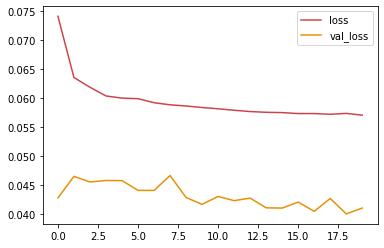

In [42]:
metric = pd.DataFrame(dnn_model.history.history)
metric.plot()

In [43]:
window_size = 24
forecast = []

train_length = len(df_house1_train)

forecast_series = df_house1[train_length - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
    forecast.append(dnn_model.predict(np.expand_dims(forecast_series[time:time + window_size], axis=-1)[np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

1/1 [==============================] - 0s 33ms/step


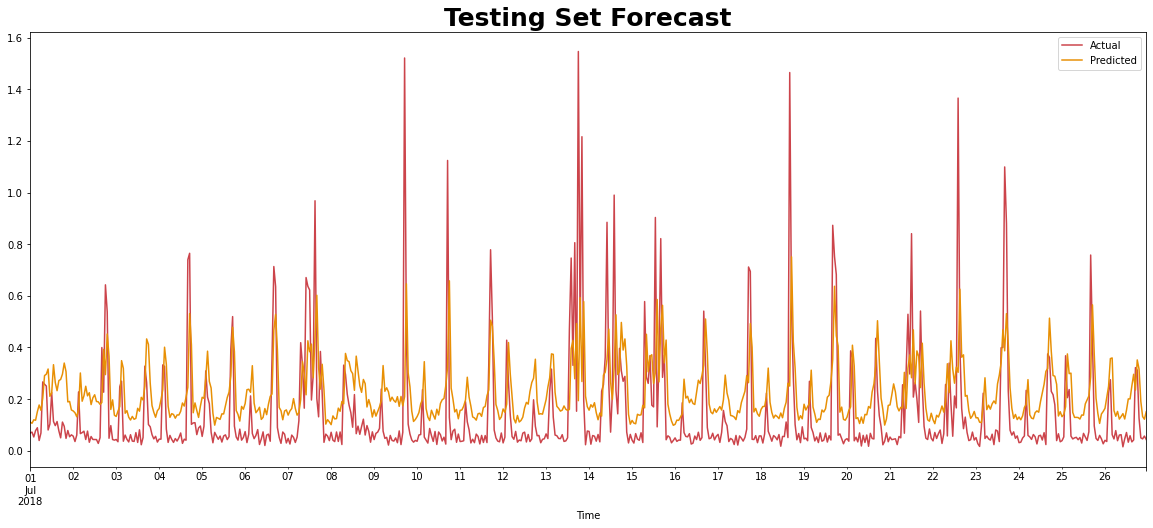

In [44]:
df_house1_test['Pred'] = results

# mae = round(mean_absolute_error(df_house1_test['House 1 Consumption'], df_house1_test['Pred']), 3)

plt.figure(figsize=(20,8))

df_house1_test['House 1 Consumption'].plot(label='Actual')
df_house1_test['Pred'].plot(label='Predicted')
#plt.text(16770, 3250, 'MAE: {}'.format(mae), fontsize=20, color='red')
plt.title('Testing Set Forecast', weight='bold', fontsize=25)
plt.legend()
plt.show()

In [45]:
mse = round(mean_squared_error(df_house1_test['House 1 Consumption'], df_house1_test['Pred']), 3)
mse


0.04

In [46]:
df_house1_test.to_csv('house1_cons_pred.csv')

# One month

## EDA

In [46]:
df_monthly_houses = pd.read_csv(houses_one_month_uninterupted, index_col='Time')
df_monthly_houses.describe()

,House 1 Consumption,House 2 Consumption,House 3 Consumption,House 4 Consumption,House 5 Consumption,House 6 Consumption,House 7 Consumption,House 8 Consumption,House 9 Consumption,House 10 Consumption,House 11 Consumption,House 12 Consumption,House 13 Consumption,House 14 Consumption,House 15 Consumption
count,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000
mean,0.211704,0.214047,0.211284,0.210549,0.213340,0.213713,0.211604,0.209626,0.210038,0.213476,0.211206,0.213748,0.215446,0.211686,0.216947
std,0.259948,0.258892,0.255902,0.257512,0.257940,0.253970,0.255864,0.248047,0.255353,0.263086,0.252872,0.257412,0.268946,0.254528,0.263879
min,0.018743,0.017000,0.015752,0.010549,0.019407,0.019258,0.013732,0.012429,0.012175,0.019810,0.019693,0.009479,0.016384,0.016397,0.017370
25%,0.056823,0.058227,0.059441,0.057614,0.057143,0.057679,0.057476,0.057641,0.058346,0.056649,0.057670,0.057511,0.058316,0.056678,0.058213
50%,0.107951,0.110431,0.103517,0.106336,0.108503,0.110327,0.105901,0.107732,0.107443,0.111428,0.108647,0.111816,0.111207,0.106361,0.106670
75%,0.281070,0.271188,0.265064,0.257230,0.267149,0.268488,0.249352,0.274037,0.265650,0.270694,0.263325,0.269453,0.275306,0.279740,0.272818
max,2.356413,1.862522,2.145977,1.625683,1.794154,1.917934,1.714956,1.952431,1.750634,2.003862,1.713820,2.051086,2.830376,1.848903,1.973210


<Axes: xlabel='Time'>

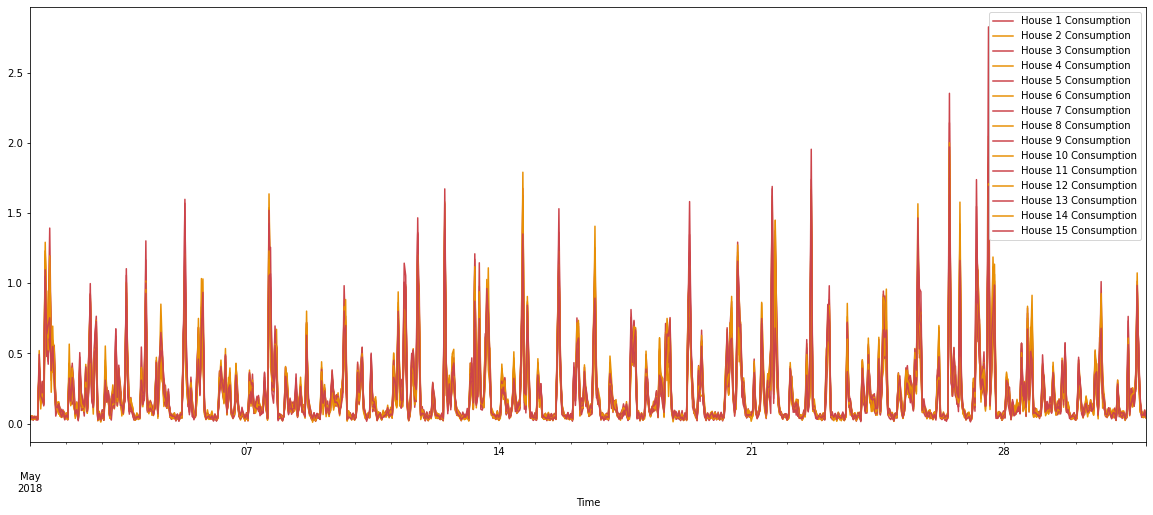

In [47]:
df_monthly_houses.index = pd.to_datetime(df_monthly_houses.index)

df_monthly_houses.plot(figsize=(20,8))

In [48]:
df_monthly_houses['Hour'] = df_monthly_houses.index.hour
df_monthly_houses['Day'] = df_monthly_houses.index.day
df_monthly_houses['Month'] = df_monthly_houses.index.month
df_monthly_houses['Quarter'] = df_monthly_houses.index.quarter
df_monthly_houses['Year'] = df_monthly_houses.index.year

df_monthly_houses.head(3)

,House 1 Consumption,House 2 Consumption,House 3 Consumption,House 4 Consumption,House 5 Consumption,House 6 Consumption,House 7 Consumption,House 8 Consumption,House 9 Consumption,House 10 Consumption,House 11 Consumption,House 12 Consumption,House 13 Consumption,House 14 Consumption,House 15 Consumption,Hour,Day,Month,Quarter,Year
Time,,,,,,,,,,,,,,,,,,,,
2018-05-01 00:00:00,0.031900,0.036835,0.029164,0.036910,0.034156,0.033852,0.033757,0.044368,0.045733,0.042976,0.028444,0.040958,0.050619,0.032687,0.033151,0,1,5,2,2018
2018-05-01 01:00:00,0.053426,0.053521,0.052972,0.036397,0.038731,0.027981,0.052646,0.031859,0.049314,0.056279,0.038805,0.037985,0.051130,0.036419,0.044550,1,1,5,2,2018
2018-05-01 02:00:00,0.036206,0.052024,0.033597,0.037578,0.022944,0.031583,0.045601,0.041594,0.029695,0.039093,0.038225,0.039690,0.036010,0.032986,0.038000,2,1,5,2,2018


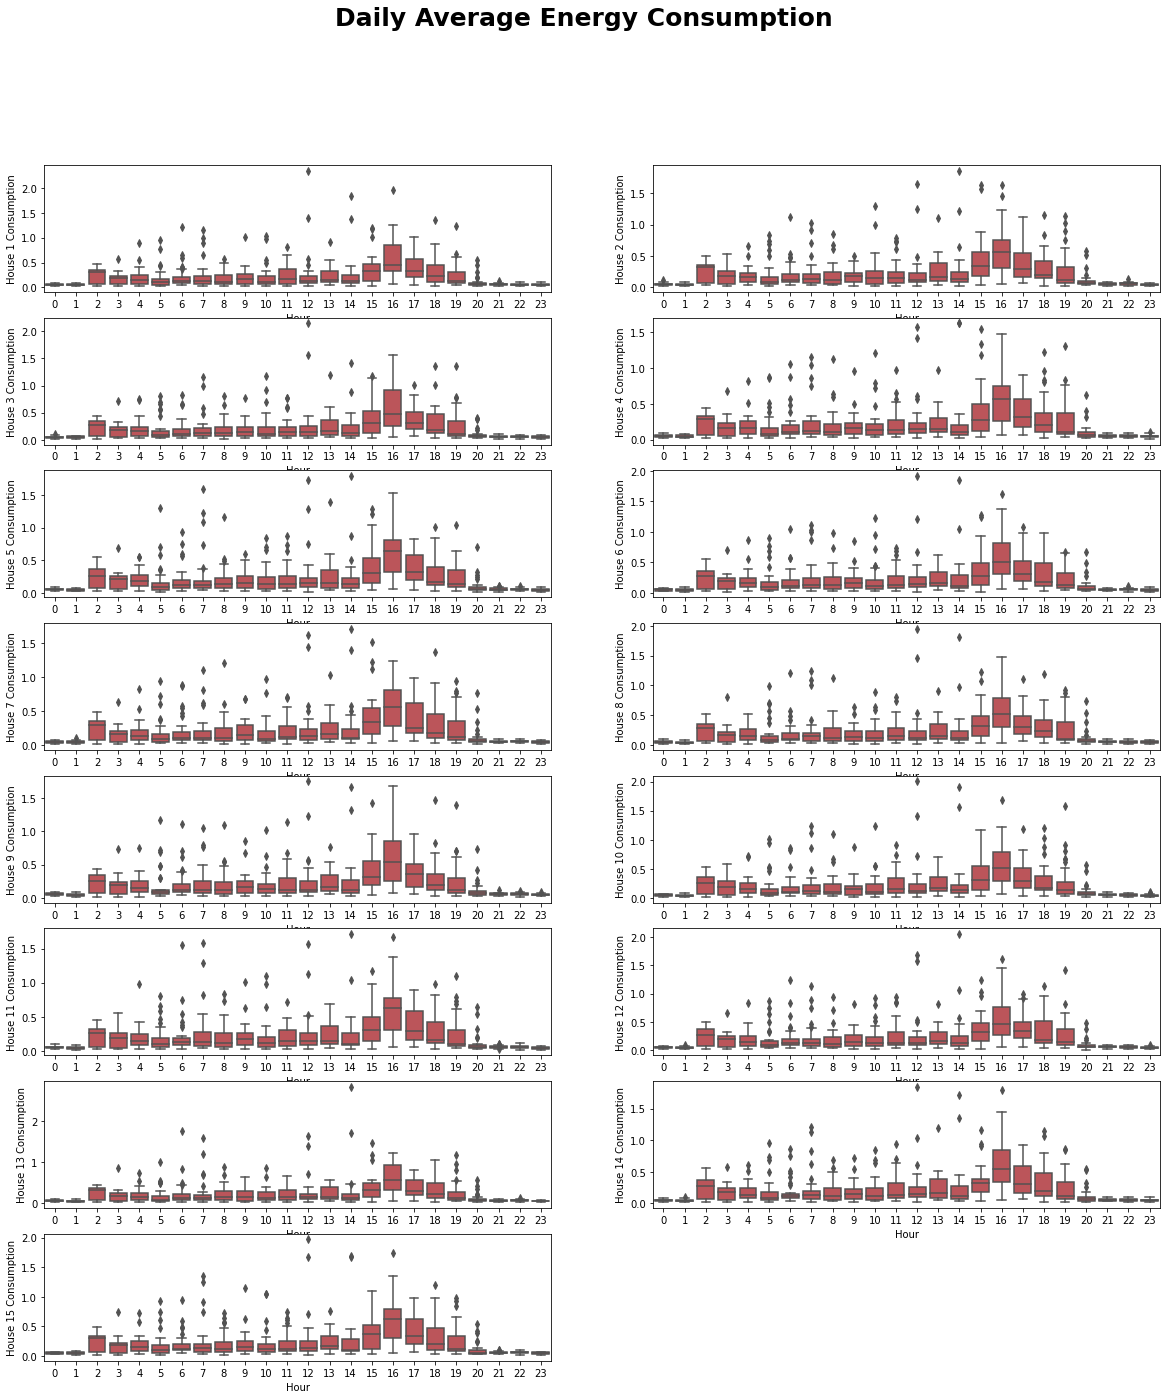

In [49]:
columns = ['House 1 Consumption', 'House 2 Consumption', 'House 3 Consumption', 'House 4 Consumption', 'House 5 Consumption', 
           'House 6 Consumption', 'House 7 Consumption', 'House 8 Consumption', 'House 9 Consumption', 'House 10 Consumption', 
           'House 11 Consumption', 'House 12 Consumption', 'House 13 Consumption', 'House 14 Consumption', 'House 15 Consumption']

f, axes = plt.subplots(nrows=8, ncols=2, figsize=(20, 22))
f.suptitle('Daily Average Energy Consumption', weight='bold', fontsize=25)
f.delaxes(axes[7][1])

for i, col in enumerate(columns):
    sns.boxplot(data=df_monthly_houses, x='Hour', y=col, ax=axes.flatten()[i], color='#cc444b')

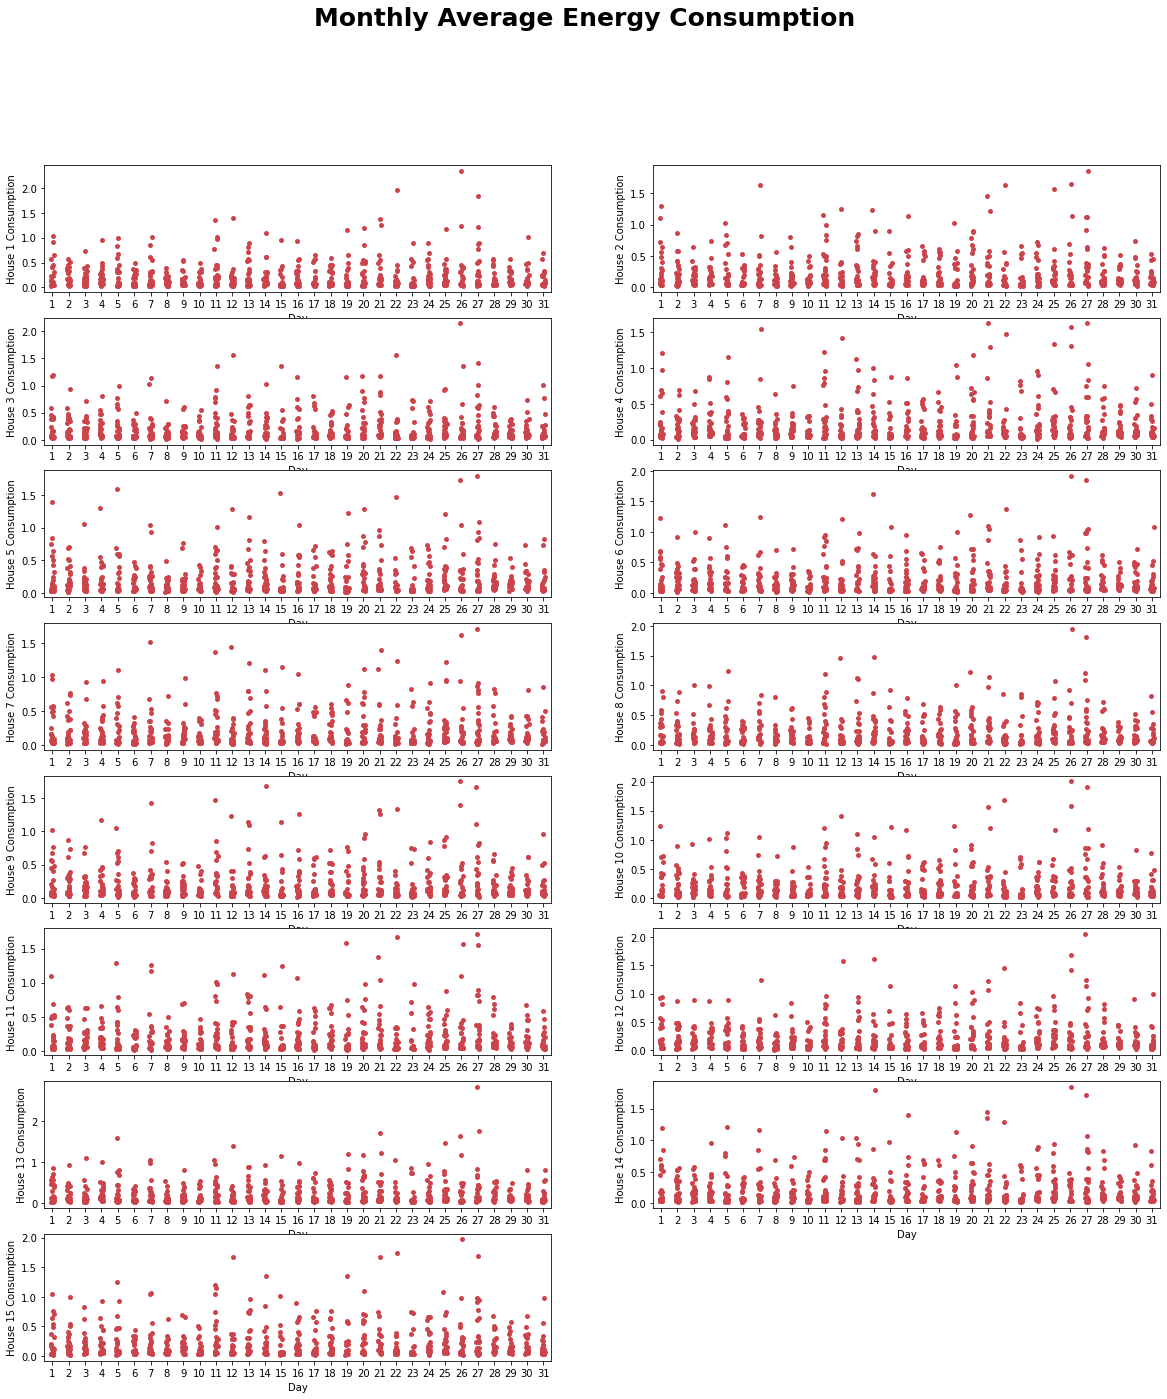

In [50]:
f, axes = plt.subplots(nrows=8, ncols=2, figsize=(20, 22))
f.suptitle('Monthly Average Energy Consumption', weight='bold', fontsize=25)
# We just need 11 figures, so we delete the last one
f.delaxes(axes[7][1])

for i, col in enumerate(columns):
    sns.stripplot(data=df_monthly_houses, x='Day', y=col, ax=axes.flatten()[i], color='#cc444b')

### We will use House 1 for the prediction modelling

The approach for all houses are the same, but the prediction will be run separately for each house to the simulation to validate it.

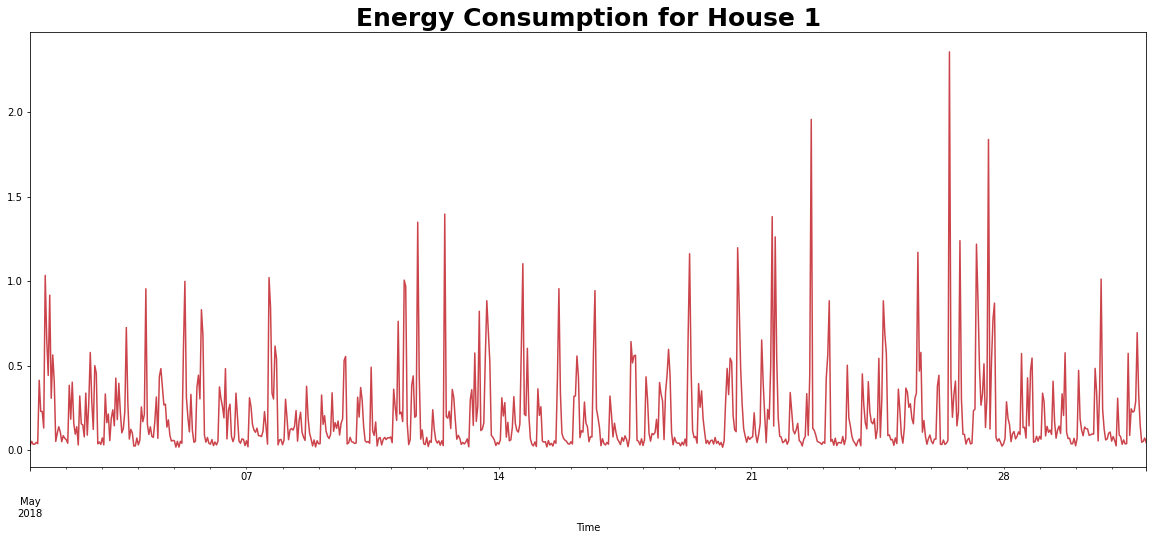

In [51]:
df_house1 = df_monthly_houses['House 1 Consumption']
df_house1.plot(figsize=(20,8))
plt.title('Energy Consumption for House 1', weight='bold', fontsize=25);

In [52]:
df_house1_train, df_house1_test = df_house1[df_house1.index < '2018-05-25'], df_house1[df_house1.index >= '2018-05-25']

print('Train:\t', len(df_house1_train))
print('Test:\t', len(df_house1_test))

Train:	 576
Test:	 168


In [53]:
df_house1_train

Time
2018-05-01 00:00:00    0.031900
2018-05-01 01:00:00    0.053426
2018-05-01 02:00:00    0.036206
2018-05-01 03:00:00    0.036479
2018-05-01 04:00:00    0.047266
                         ...   
2018-05-24 19:00:00    0.087571
2018-05-24 20:00:00    0.091509
2018-05-24 21:00:00    0.062039
2018-05-24 22:00:00    0.065247
2018-05-24 23:00:00    0.030053
Name: House 1 Consumption, Length: 576, dtype: float64

In [54]:
df_house1_test

Time
2018-05-25 00:00:00    0.074107
2018-05-25 01:00:00    0.040340
2018-05-25 02:00:00    0.362505
2018-05-25 03:00:00    0.238470
2018-05-25 04:00:00    0.092393
                         ...   
2018-05-31 19:00:00    0.147937
2018-05-31 20:00:00    0.048194
2018-05-31 21:00:00    0.053454
2018-05-31 22:00:00    0.072915
2018-05-31 23:00:00    0.045410
Name: House 1 Consumption, Length: 168, dtype: float64

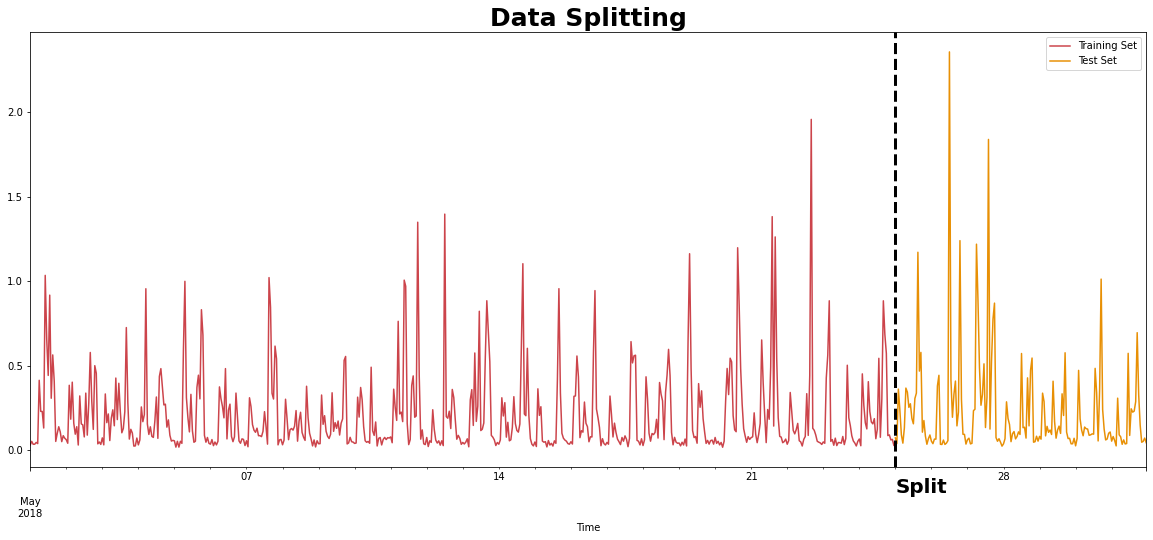

In [55]:
plt.figure(figsize=(20,8)) # lower dpi

df_house1_train.plot(label='Training Set')
df_house1_test.plot(label='Test Set')
plt.axvline('2018-05-25', color='black', ls='--', lw=3)
plt.text('2018-05-25', -0.25, 'Split', fontsize=20, fontweight='bold')
plt.title('Data Splitting', weight='bold', fontsize=25)
plt.legend();

## Modelling

### 1. Prophet

#### For some reason, after updating the library, it gives a lot of errors, I don't know why, but yeah.

Prophet is an open-source library for univariate (one variable) time series forecasting developed by Facebook. It works best with time series that have strong seasonal effects and several seasons of historical data

Official Documentation: [Here](http://facebook.github.io/prophet/#:~:text=Prophet%20is%20a%20procedure%20for,several%20seasons%20of%20historical%20data.)

Helpful Resources: 
* https://machinelearningmastery.com/time-series-forecasting-with-prophet-in-python/
* https://www.kaggle.com/code/prashant111/tutorial-time-series-forecasting-with-prophet/notebook

In [56]:
def index_to_column(data):
    data = data.reset_index()
    data['Time'] = pd.to_datetime(data['Time'])
    data = data.sort_values('Time')
    
    data = data.rename(columns={'Time': 'ds', 'House 1 Consumption': 'y'})
    return data

In [57]:
prophet_train = index_to_column(df_house1_train)
prophet_test = index_to_column(df_house1_test)

In [58]:
prophet_train

,ds,y
0,2018-05-01 00:00:00,0.031900
1,2018-05-01 01:00:00,0.053426
2,2018-05-01 02:00:00,0.036206
3,2018-05-01 03:00:00,0.036479
4,2018-05-01 04:00:00,0.047266
...,...,...
571,2018-05-24 19:00:00,0.087571
572,2018-05-24 20:00:00,0.091509
573,2018-05-24 21:00:00,0.062039
574,2018-05-24 22:00:00,0.065247


In [59]:
prophet_model = Prophet(interval_width=0.95)

prophet_model.fit(prophet_train)
prophet_pred = prophet_model.predict(prophet_test[['ds']])

16:11:34 - cmdstanpy - INFO - Chain [1] start processing
16:11:34 - cmdstanpy - INFO - Chain [1] done processing


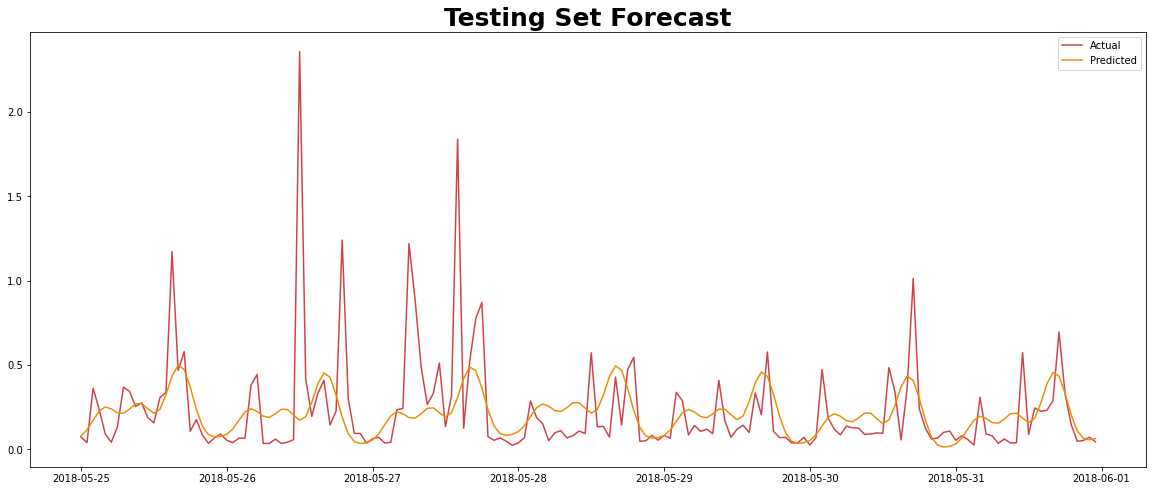

In [60]:
plt.figure(figsize=(20,8))
plt.plot(prophet_test['ds'], prophet_test['y'], label='Actual')
plt.plot(prophet_pred['ds'], prophet_pred['yhat'], label='Predicted')
plt.title('Test Forecasting', weight='bold', fontsize=40)
#plt.text(16770, 3250, 'MAE: {}'.format(mae), fontsize=20, color='red')
plt.title('Testing Set Forecast', weight='bold', fontsize=25)
plt.legend();

In [61]:
mse = mean_squared_error(prophet_test['y'], prophet_pred['yhat'])
print('MSE: ', mse)

MSE:  0.08362695580309547


### 2. XGBoost

XGBoost is short for Extreme Gradient Boosting and is an efficient implementation of the stochastic gradient boosting machine learning algorithm

The stochastic gradient boosting algorithm, also called gradient boosting machines or tree boosting, is a powerful machine learning technique that performs well or even best on a wide range of challenging machine learning problems

To be able to use XGBoost for time series forecasting, the data should be transformed into supervised learning before feeding it into the model

Official Documentation: [here](https://xgboost.readthedocs.io/en/stable/python/python_api.html)

Helpful Resources:
* https://machinelearningmastery.com/xgboost-for-time-series-forecasting/
* https://www.kaggle.com/code/robikscube/tutorial-time-series-forecasting-with-xgboost

In [62]:
def date_transform(data):
    df = pd.DataFrame(data.values, index=data.index, columns=["House 1 Consumption"])
    
    df['Hour'] = df.index.hour
    df['Day'] = df.index.day
    df['Dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.weekofyear
    df['Month'] = df.index.month
    df['Quarter'] = df.index.quarter
    df['Year'] = df.index.year
    
    X = df.drop('House 1 Consumption', axis=1)
    y = df['House 1 Consumption']
    
    return X, y

In [63]:
X_train, y_train = date_transform(df_house1_train)
X_test, y_test = date_transform(df_house1_test)

C:\Users\20200628\AppData\Local\Temp\ipykernel_19928\317430643.py:7: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['weekofyear'] = df.index.weekofyear
C:\Users\20200628\AppData\Local\Temp\ipykernel_19928\317430643.py:7: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['weekofyear'] = df.index.weekofyear


In [64]:
xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.05, early_stopping_rounds=10)
xgb_model.fit(X_train, y_train, eval_metric='mae', eval_set=[(X_train, y_train), (X_test, y_test)])
xgb_pred = xgb_model.predict(X_test)

[0]	validation_0-mae:0.33909	validation_1-mae:0.34501
[1]	validation_0-mae:0.32626	validation_1-mae:0.33462
[2]	validation_0-mae:0.31415	validation_1-mae:0.32533
[3]	validation_0-mae:0.30267	validation_1-mae:0.31655
[4]	validation_0-mae:0.29182	validation_1-mae:0.30817
[5]	validation_0-mae:0.28165	validation_1-mae:0.30037
[6]	validation_0-mae:0.27200	validation_1-mae:0.29290
[7]	validation_0-mae:0.26290	validation_1-mae:0.28453
[8]	validation_0-mae:0.25434	validation_1-mae:0.27810
[9]	validation_0-mae:0.24609	validation_1-mae:0.27052
[10]	validation_0-mae:0.23836	validation_1-mae:0.26382
[11]	validation_0-mae:0.23100	validation_1-mae:0.25772
[12]	validation_0-mae:0.22398	validation_1-mae:0.25218
[13]	validation_0-mae:0.21731	validation_1-mae:0.24625
[14]	validation_0-mae:0.21106	validation_1-mae:0.24119
[15]	validation_0-mae:0.20527	validation_1-mae:0.23625
[16]	validation_0-mae:0.19977	validation_1-mae:0.23179
[17]	validation_0-mae:0.19443	validation_1-mae:0.22750
[18]	validation_0-ma

[37]	validation_0-mae:0.13009	validation_1-mae:0.18212
[38]	validation_0-mae:0.12823	validation_1-mae:0.18077
[39]	validation_0-mae:0.12652	validation_1-mae:0.17954
[40]	validation_0-mae:0.12488	validation_1-mae:0.17837
[41]	validation_0-mae:0.12324	validation_1-mae:0.17728
[42]	validation_0-mae:0.12175	validation_1-mae:0.17629
[43]	validation_0-mae:0.12011	validation_1-mae:0.17543
[44]	validation_0-mae:0.11855	validation_1-mae:0.17469
[45]	validation_0-mae:0.11726	validation_1-mae:0.17390
[46]	validation_0-mae:0.11600	validation_1-mae:0.17307
[47]	validation_0-mae:0.11447	validation_1-mae:0.17295
[48]	validation_0-mae:0.11320	validation_1-mae:0.17253
[49]	validation_0-mae:0.11207	validation_1-mae:0.17193
[50]	validation_0-mae:0.11086	validation_1-mae:0.17196
[51]	validation_0-mae:0.10956	validation_1-mae:0.17159
[52]	validation_0-mae:0.10852	validation_1-mae:0.17103
[53]	validation_0-mae:0.10754	validation_1-mae:0.17050
[54]	validation_0-mae:0.10659	validation_1-mae:0.17025
[55]	valid

C:\Users\20200628\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[59]	validation_0-mae:0.10122	validation_1-mae:0.16837
[60]	validation_0-mae:0.10059	validation_1-mae:0.16816
[61]	validation_0-mae:0.09955	validation_1-mae:0.16801
[62]	validation_0-mae:0.09883	validation_1-mae:0.16772
[63]	validation_0-mae:0.09785	validation_1-mae:0.16760
[64]	validation_0-mae:0.09721	validation_1-mae:0.16734
[65]	validation_0-mae:0.09643	validation_1-mae:0.16714
[66]	validation_0-mae:0.09565	validation_1-mae:0.16696
[67]	validation_0-mae:0.09481	validation_1-mae:0.16668
[68]	validation_0-mae:0.09432	validation_1-mae:0.16649
[69]	validation_0-mae:0.09343	validation_1-mae:0.16627
[70]	validation_0-mae:0.09296	validation_1-mae:0.16627
[71]	validation_0-mae:0.09216	validation_1-mae:0.16615
[72]	validation_0-mae:0.09141	validation_1-mae:0.16608
[73]	validation_0-mae:0.09099	validation_1-mae:0.16595
[74]	validation_0-mae:0.09066	validation_1-mae:0.16578
[75]	validation_0-mae:0.09029	validation_1-mae:0.16579
[76]	validation_0-mae:0.08961	validation_1-mae:0.16570
[77]	valid

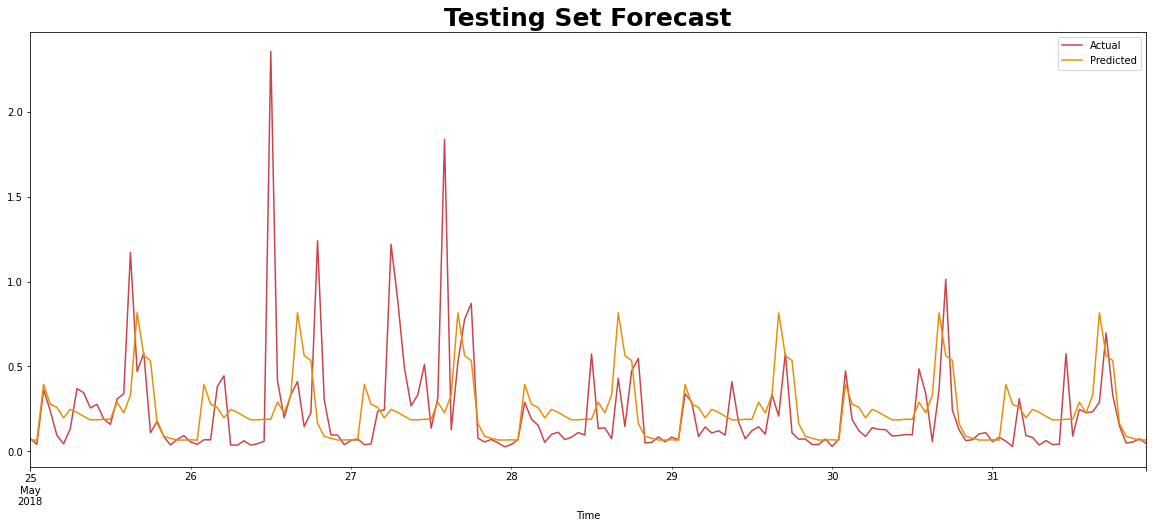

In [64]:
# mae = round(mean_absolute_error(y_test, xgb_pred), 3)

df_plot = pd.DataFrame({'y_test':y_test, 'xgb_pred':xgb_pred})

plt.figure(figsize=(20,8))

df_plot['y_test'].plot(label='Actual')
df_plot['xgb_pred'].plot(label='Predicted')
# plt.text(0, 0, 'MAE: {}'.format(mae), fontsize=2, color='red')
plt.title('Testing Set Forecast', weight='bold', fontsize=25)
plt.legend()
plt.show()

In [65]:
mse = mean_squared_error(y_test, xgb_pred)
print('MSE: ', mse)

MSE:  0.0937293351216117


### Neural Network

The Deep Learning framework we are using is Tensorflow

#### Preparing features and labels
Before feeding the data into Neural Network, we have to do some modification to the data so they can be accepted by the model. We are going to use windowing technique which basically group the data into feature and label. The label will be the next value. You can take a look at the next few cells to give an idea what we are going to do

Official Documentation: [Here](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)

Helpful Resource:

* https://stackoverflow.com/questions/55429307/how-to-use-windows-created-by-the-dataset-window-method-in-tensorflow-2-0

In [66]:
df_house1_train = df_house1_train.to_frame('House 1 Consumption')
df_house1_train

,House 1 Consumption
Time,
2018-05-01 00:00:00,0.031900
2018-05-01 01:00:00,0.053426
2018-05-01 02:00:00,0.036206
2018-05-01 03:00:00,0.036479
2018-05-01 04:00:00,0.047266
...,...
2018-05-24 19:00:00,0.087571
2018-05-24 20:00:00,0.091509
2018-05-24 21:00:00,0.062039


In [67]:
df_house1_test = df_house1_test.to_frame('House 1 Consumption')
df_house1_test

,House 1 Consumption
Time,
2018-05-25 00:00:00,0.074107
2018-05-25 01:00:00,0.040340
2018-05-25 02:00:00,0.362505
2018-05-25 03:00:00,0.238470
2018-05-25 04:00:00,0.092393
...,...
2018-05-31 19:00:00,0.147937
2018-05-31 20:00:00,0.048194
2018-05-31 21:00:00,0.053454


In [68]:
dataset = tf.expand_dims(df_house1_train.head(10), axis=-1)

# Generate a tf dataset with 10 elements (i.e. numbers 0 to 9)
dataset = tf.data.Dataset.from_tensor_slices(dataset)

# Window the data but only take those with the specified size
dataset = dataset.window(5, shift=1, drop_remainder=True)

# Flatten the windows by putting its elements in a single batch
dataset = dataset.flat_map(lambda window: window.batch(5))

# Create tuples with features (first four elements of the window) and labels (last element)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))

# # Shuffle the windows
# dataset = dataset.shuffle(buffer_size=10)

# # Create batches of windows
# dataset = dataset.batch(2).prefetch(1)

# Print the results
for x,y in dataset:
    print("x = ", x.numpy())
    print("y = ", y.numpy())
    print()

x =  [[[0.03190036]]

 [[0.05342578]]

 [[0.03620557]]

 [[0.03647908]]]
y =  [[0.04726568]]

x =  [[[0.05342578]]

 [[0.03620557]]

 [[0.03647908]]

 [[0.04726568]]]
y =  [[0.04029024]]

x =  [[[0.03620557]]

 [[0.03647908]]

 [[0.04726568]]

 [[0.04029024]]]
y =  [[0.41453382]]

x =  [[[0.03647908]]

 [[0.04726568]]

 [[0.04029024]]

 [[0.41453382]]]
y =  [[0.23080742]]

x =  [[[0.04726568]]

 [[0.04029024]]

 [[0.41453382]]

 [[0.23080742]]]
y =  [[0.23026463]]

x =  [[[0.04029024]]

 [[0.41453382]]

 [[0.23080742]]

 [[0.23026463]]]
y =  [[0.1324208]]



In [69]:
def windowing(data, window_size, shuffle_buffer, batch_size):
    dataset = tf.expand_dims(data, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(dataset)
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True) # window size = 24 + 1 (test)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1])) # (train, test) 
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [70]:
train = windowing(df_house1_train['House 1 Consumption'], 24, 72, 32)
test = windowing(df_house1_test['House 1 Consumption'], 24, 72, 32)

In [71]:
dnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=16, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[24,1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, activation='relu')),
    tf.keras.layers.Dense(16),
    tf.keras.layers.Dense(1)
])

dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 24, 16)            64        
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               4224      
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 4,833
Trainable params: 4,833
Non-trainable params: 0
_________________________________________________________________


In [72]:
dnn_model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
dnn_model.fit(train, validation_data=test, epochs=20)

Epoch 1/20


18/18 [==============================] - 5s 49ms/step - loss: 0.0680 - val_loss: 0.0980
Epoch 2/20
18/18 [==============================] - 0s 21ms/step - loss: 0.0589 - val_loss: 0.0980
Epoch 3/20
18/18 [==============================] - 1s 36ms/step - loss: 0.0563 - val_loss: 0.0977
Epoch 4/20
18/18 [==============================] - 0s 24ms/step - loss: 0.0550 - val_loss: 0.0973
Epoch 5/20
18/18 [==============================] - 0s 20ms/step - loss: 0.0539 - val_loss: 0.0980
Epoch 6/20
18/18 [==============================] - 1s 29ms/step - loss: 0.0529 - val_loss: 0.0979
Epoch 7/20
18/18 [==============================] - 1s 27ms/step - loss: 0.0521 - val_loss: 0.0986
Epoch 8/20
18/18 [==============================] - 1s 26ms/step - loss: 0.0508 - val_loss: 0.0993
Epoch 9/20
18/18 [==============================] - 1s 24ms/step - loss: 0.0501 - val_loss: 0.1005
Epoch 10/20
18/18 [==============================] - 1s 31ms/step - loss: 0.0496 - val_loss: 0.1033
Epoch 11/20
18/18 [=

<Axes: >

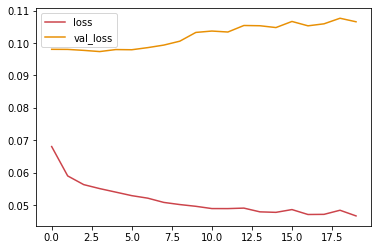

In [73]:
metric = pd.DataFrame(dnn_model.history.history)
metric.plot()

In [74]:
window_size = 24
forecast = []

train_length = len(df_house1_train)

forecast_series = df_house1[train_length - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
    forecast.append(dnn_model.predict(np.expand_dims(forecast_series[time:time + window_size], axis=-1)[np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

1/1 [==============================] - 0s 60ms/step


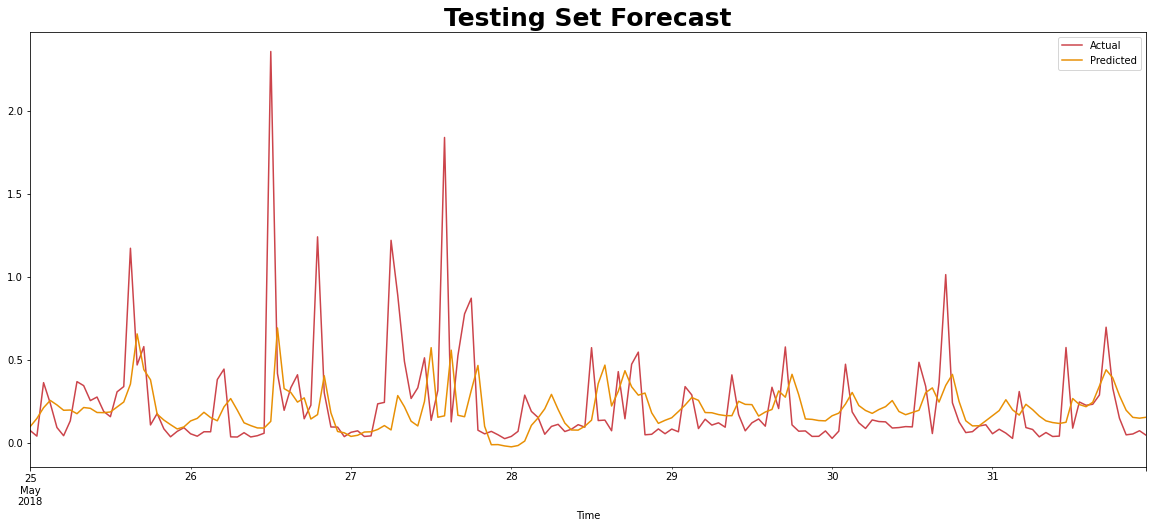

In [75]:
df_house1_test['Pred'] = results

mae = round(mean_absolute_error(df_house1_test['House 1 Consumption'], df_house1_test['Pred']), 3)

plt.figure(figsize=(20,8))

df_house1_test['House 1 Consumption'].plot(label='Actual')
df_house1_test['Pred'].plot(label='Predicted')
#plt.text(16770, 3250, 'MAE: {}'.format(mae), fontsize=20, color='red')
plt.title('Testing Set Forecast', weight='bold', fontsize=25)
plt.legend()
plt.show()

In [76]:
mse = mean_squared_error(df_house1_test['House 1 Consumption'], df_house1_test['Pred'])
print('MSE: ', mse)

MSE:  0.09709314842309166
